<a href="https://colab.research.google.com/github/manhili/Machine-Learning/blob/main/GaussianMixtureModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning Project : Unsupervised learning**

**Case study:** *Clustering*\
**Dataset:** malaria_clinical_data without labels.

#**Importing required libraries**

In [204]:
#importing required libraries & dataset for the project
import pandas as pd
import numpy as np  
import seaborn as sns

import matplotlib.pyplot as plt  
from plotnine import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

%config InlineBackend.figure_format='retina'
%matplotlib inline

#**Importing dataset**

In [205]:
url = "https://raw.githubusercontent.com/manhili/Machine-Learning/main/malaria_clinical_data.csv"
df = pd.read_csv(url)

In [206]:
df.head()

,wbc_count,rbc_count,hb_level,hematocrit,mean_cell_volume,mean_corp_hb,mean_cell_hb_conc,platelet_count,platelet_distr_width,mean_platelet_vl,neutrophils_percent,lymphocytes_percent,mixed_cells_percent,neutrophils_count,lymphocytes_count,mixed_cells_count,RBC_dist_width_Percent
0,5.7,2.8,5.8,16.1,59.0,21.1,36.0,156.0,8.2,6.8,61.8,31.7,6.5,3.6,1.8,0.3,19.0
1,7.8,3.5,9.2,24.2,70.0,26.4,37.8,55.0,16.5,7.6,68.5,23.6,7.9,5.4,1.8,0.6,14.4
2,8.2,1.0,2.3,5.7,59.0,23.8,40.4,20.0,2.3,5.9,32.8,53.3,13.9,2.8,4.3,1.1,18.0
3,15.9,3.3,10.1,25.1,75.0,30.2,40.2,132.0,17.2,6.2,82.6,11.5,5.9,13.2,1.8,0.9,13.7
4,4.5,2.1,5.7,16.1,78.0,27.1,35.4,85.0,16.1,6.8,83.7,11.3,5.0,3.8,0.5,0.2,15.0


In [207]:
data = pd.DataFrame(df, columns = ['mean_cell_volume', 'rbc_count'])
data.head()

,mean_cell_volume,rbc_count
0,59.0,2.8
1,70.0,3.5
2,59.0,1.0
3,75.0,3.3
4,78.0,2.1


#**Dataset Distribution**

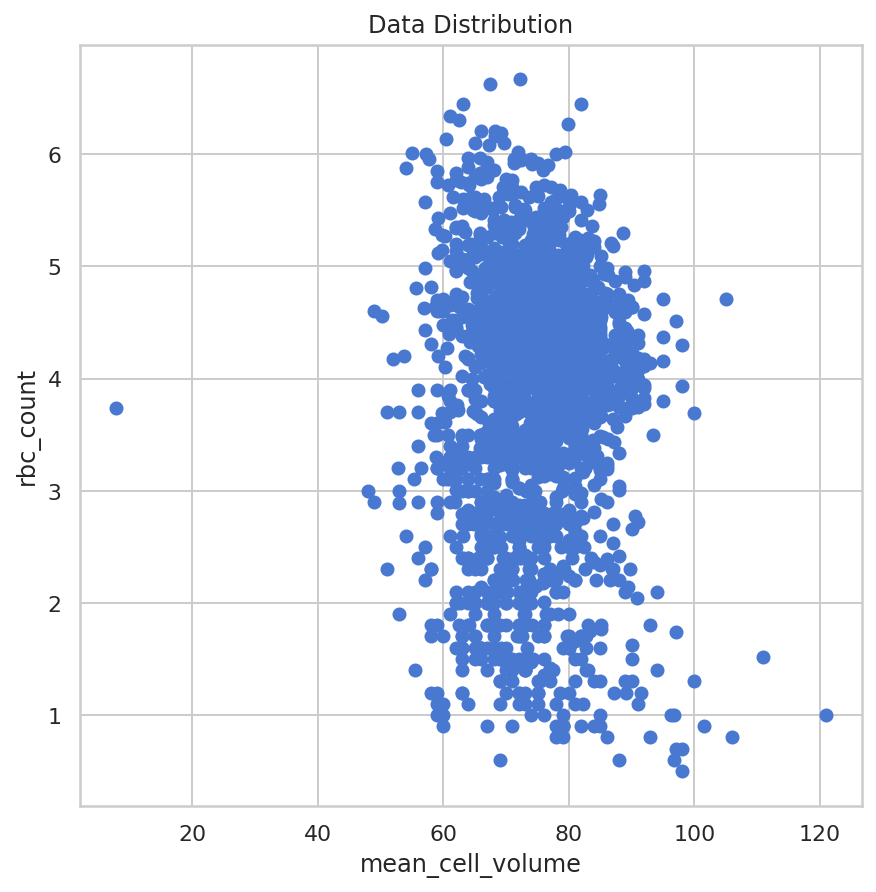

In [208]:
plt.figure(figsize=(7,7))
plt.scatter(data["mean_cell_volume"],data["rbc_count"])
plt.xlabel('mean_cell_volume')
plt.ylabel('rbc_count')
plt.title('Data Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


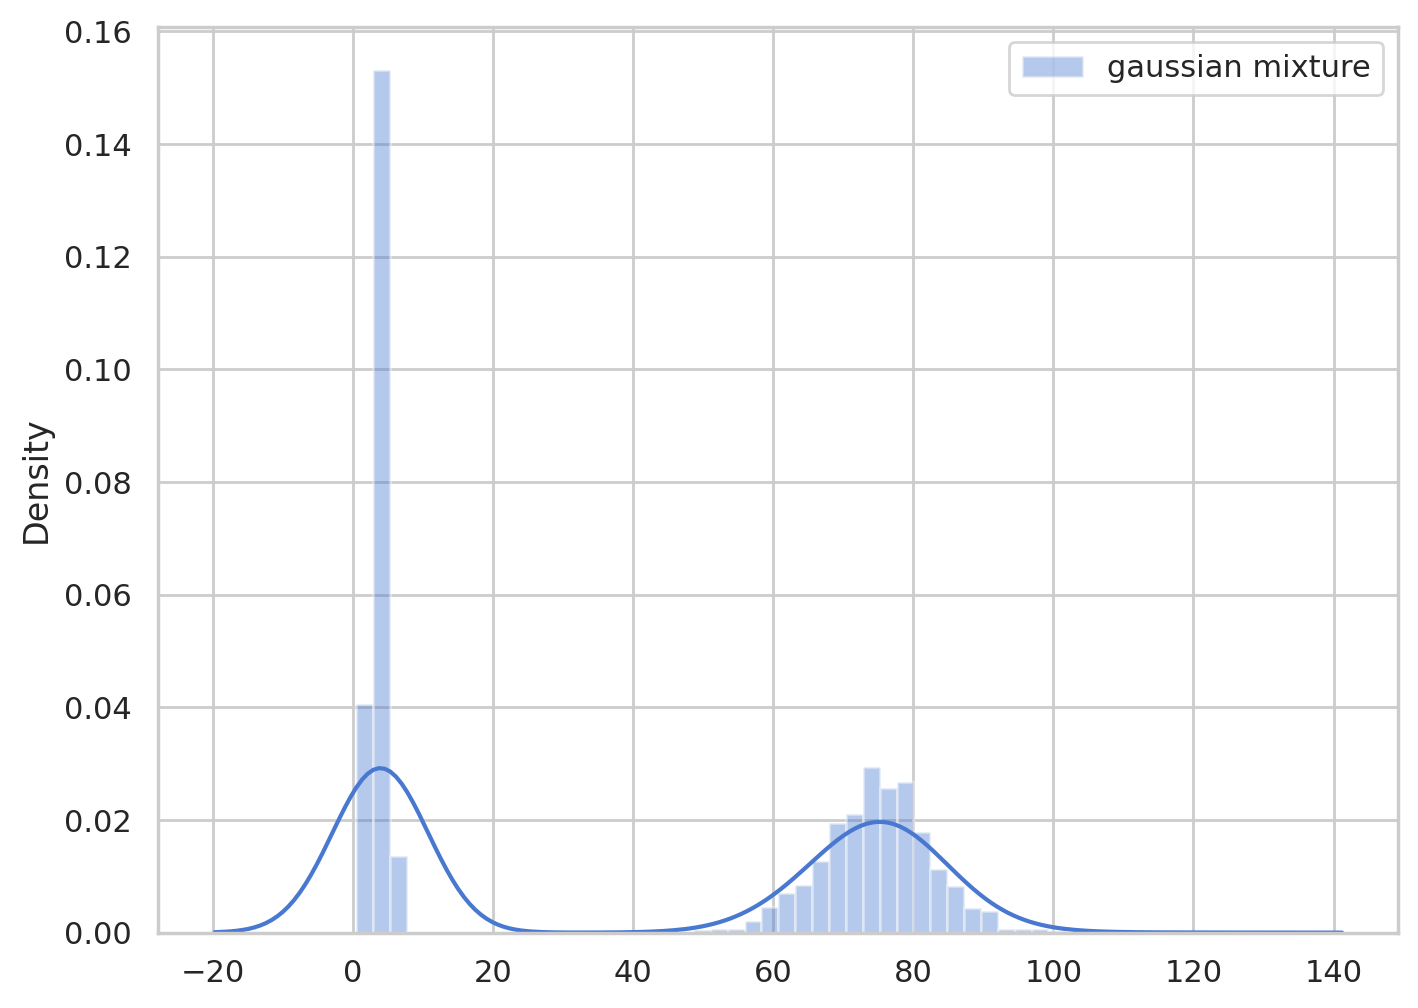

In [209]:
# plot
fig = plt.figure(figsize=(8, 6), dpi=100)
sns.distplot(data, bins=50, kde=True, norm_hist= True, label='gaussian mixture')
plt.legend ()
plt.show()

#**Hard clustering : K-means**

Let's predict the number of clusters for Kmeans.

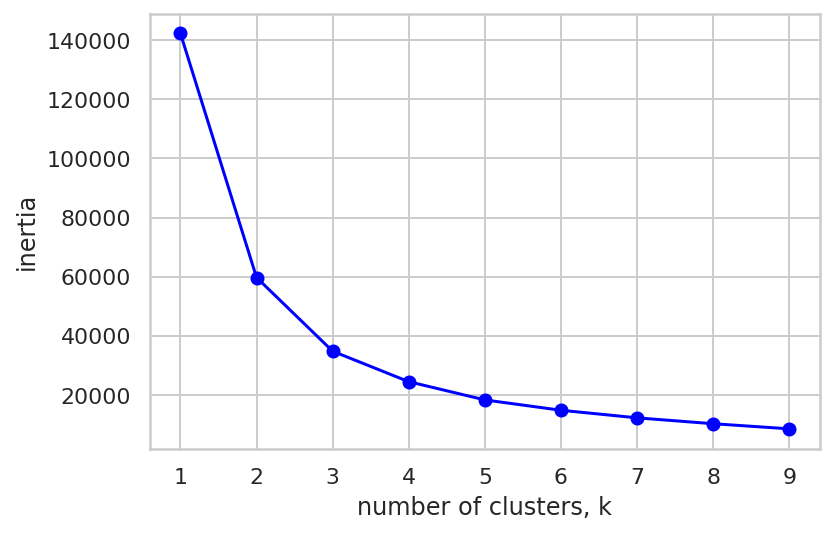

In [210]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The figure above shows that after 3 clusters (at the elbow), the change in the value of inertia is no longer significant, and most likely, neither is the variance of the rest of the data after the elbow point. Therefore we can discard everything after k=4 and proceed to the last step in the process.

Silhouette score for K-means:  0.07345604464034744


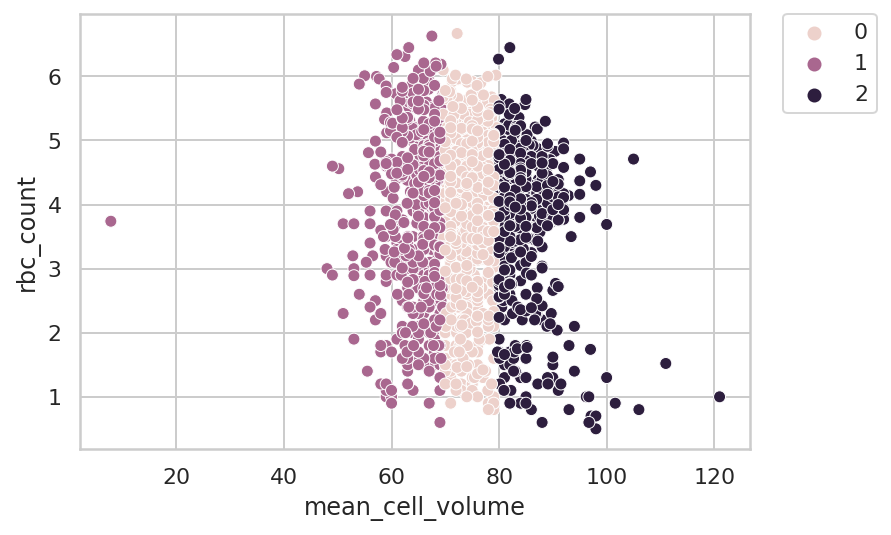

In [211]:
#training k-means model
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data)

#predictions from kmeans
pred = kmeans.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = pred
frame.columns = ['mean_cell_volume', 'rbc_count', 'cluster']

#plotting results
sns.set(style="whitegrid", palette="muted")
ax=sns.scatterplot(x="mean_cell_volume", y= "rbc_count", hue="cluster", data=frame)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#evaluation using silhouhette score
print("Silhouette score for K-means: ", silhouette_score(data, labels))

The score of less than 0 means that data belonging to clusters may be wrong/incorrect.

#**Soft clustering : Guassian Mixture Model (aka. GMM)**

In [212]:
data = pd.DataFrame(df, columns = ['mean_cell_volume', 'rbc_count'])

# training gaussian mixture model 
gmm = GaussianMixture(n_components=3 , init_params='random')
gmm.fit(data)
print('Converged:', gmm.converged_) # check if the model has converged

#predictions from gmm
labels = gmm.predict(data)

#probability of each data point that belong to a cluster
labels_p = gmm.predict_proba(data)
labels_p

#evaluation using silhouhette score
print("Silhouette score for GMM: ", silhouette_score(data, labels))

Converged: True
Silhouette score for GMM:  0.10033777542643642


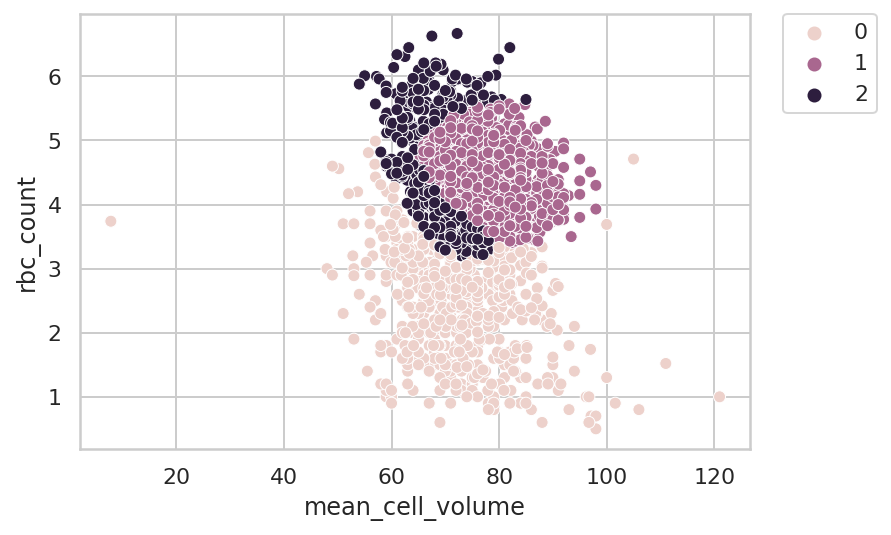

In [213]:
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['mean_cell_volume', 'rbc_count', 'cluster']

#plotting results
sns.set(style="whitegrid", palette="muted")
ax=sns.scatterplot(x="mean_cell_volume", y= "rbc_count", hue="cluster", data=frame)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [214]:
# print the converged log-likelihood value
print(gmm.lower_bound_)
 
# print the number of iterations needed for the log-likelihood value to converge
print(gmm.n_iter_)

-4.899234587024467
18


Hence, it needed 2 iterations for the log-likelihood to converge. If more iterations are performed, no appreciable change in the log-likelihood value can be observed.

#**Estimation of number of components for GMM using AIC and BIC criterions**

Text(0.5, 0, 'n_components')

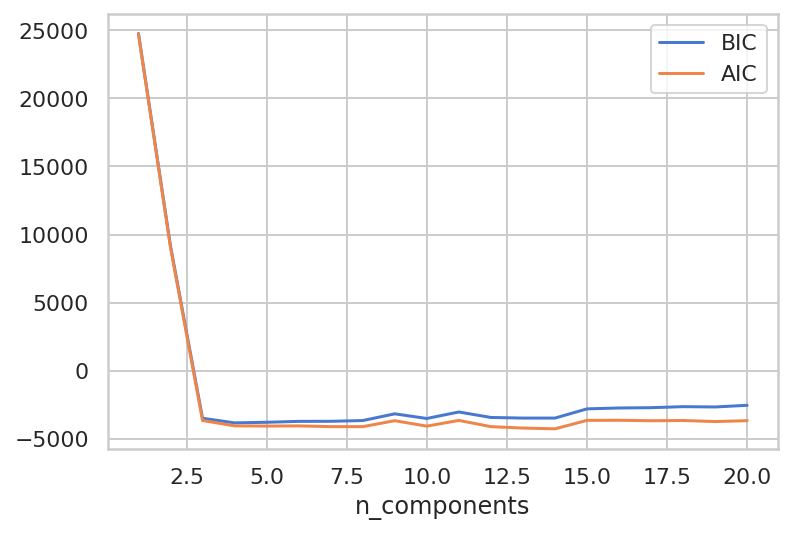

In [215]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data) for n in n_components]

plt.plot(n_components, [m.bic(data) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(data) for m in models], label = 'AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The optimal value for the parameter is where the AIC and BIC are minimizes.
Both AIC and BIC tell here that around 4 is a good choice.

In [216]:
data = pd.DataFrame(df, columns = ['mean_cell_volume', 'rbc_count'])

# training gaussian mixture model 
gmm = GaussianMixture(n_components=4 , init_params='random')
gmm.fit(data)
print('Converged:', gmm.converged_) # check if the model has converged

#predictions from gmm
labels = gmm.predict(data)

#probability of each data point that belong to a cluster
labels_p = gmm.predict_proba(data)
labels_p

#evaluation using silhouhette score
print("Silhouette score for GMM: ", silhouette_score(data, labels))

Converged: True
Silhouette score for GMM:  0.1108661588034186


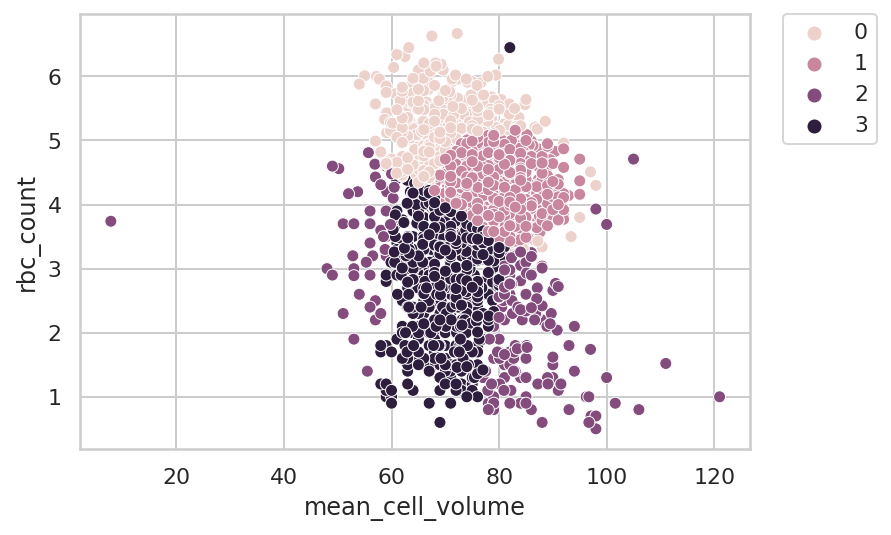

In [217]:
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['mean_cell_volume', 'rbc_count', 'cluster']

#plotting results
sns.set(style="whitegrid", palette="muted")
ax=sns.scatterplot(x="mean_cell_volume", y= "rbc_count", hue="cluster", data=frame)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [218]:
# print the converged log-likelihood value
print(gmm.lower_bound_)
 
# print the number of iterations needed for the log-likelihood value to converge
print(gmm.n_iter_)

-4.885525120324718
20


#**Conclusion**

After applying different clustering approches we could say that GMM done a good work comparing to Kmeans, but we have to keep in mind that we have a sort of overlapping data.